In [90]:
from __future__ import print_function
import numpy as np
import json
import glob 
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import TreebankWordTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse, io
%matplotlib inline

In [5]:
recipes = []
path = 'jsons/parsed*.json'   
files=glob.glob(path)   
for file in files: 
    with open(file) as f:
        for line in f:
            recipes.append(json.loads(line))

# Statistics

### Dataset Basic Information

In [47]:
print("There are {} recipes in this dataset".format(len(recipes)))

There are 4693 recipes in this dataset


In [48]:
print(type(recipes[0]))

<type 'dict'>


In [49]:
print(recipes[0].keys())

[u'rating', u'code', u'name', u'amounts', u'servings', u'calories', u'reviews', u'num_reviews', u'verbs', u'steps', u'time', u'tag', u'tips', u'ing', u'desc']


### Most Popular Ingredients

In [50]:
from collections import Counter

In [51]:
all_ings = [ing for ings in [recipe['ing'] for recipe in recipes] for ing in ings]
count = Counter(all_ings)
top_n =  count.most_common(10)

In [52]:
print ("The top 10 most commonly used ingredients are: \n\n{}".format
       ("\n".join(str(ing) for ing in top_n)))

The top 10 most commonly used ingredients are: 

(u'salt', 1728)
(u'butter', 1471)
(u'white sugar', 1327)
(u'all-purpose flour', 1212)
(u'egg', 1204)
(u'milk', 910)
(u'vanilla extract', 820)
(u'garlic', 807)
(u'olive oil', 596)
(u'vegetable oil', 556)


* Potential Challenge/To Do: Format ingredients to separate quantity/actual ingredient

### Rating Distribution

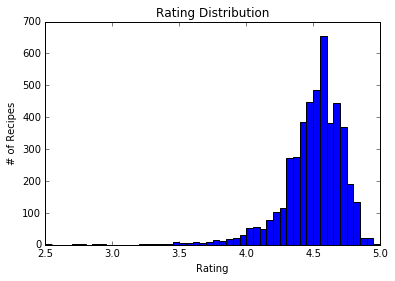

In [53]:
plt.hist([y['rating'] for y in recipes],bins= 50)
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("# of Recipes")
plt.show()

* Potential Challenge/To Do: It seems as though our dataset only consists of recipes that already have high ratings. We need to expand our dataset in order to avoid selection bias.

### Cooking Time Distribution

In [54]:
import math

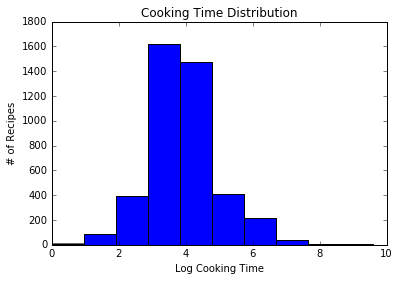

In [55]:
plt.hist([math.log(y['time']) for y in recipes if (y['time'] != -1)])
plt.title("Cooking Time Distribution")
plt.xlabel("Log Cooking Time")
plt.ylabel("# of Recipes")
plt.show()

* Probably a bug in the code thats encoding the times inconsistently. Discarded values over 1000 for now but still not making sense. Should take this plot out.

### Number of Reviews Distribution

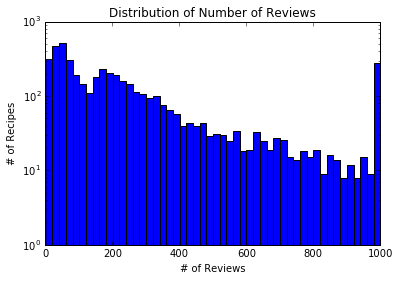

In [56]:
plt.hist([len(y['reviews']) for y in recipes], bins = 50, log = True)
plt.title("Distribution of Number of Reviews")
plt.xlabel("# of Reviews")
plt.ylabel("# of Recipes")
plt.show()

* The cutoff for maximum reviews seems to be 1000
* Why is the bin for 500 reviews empty...?
* Number of reviews seem pretty evenly distributed throughout the recipes. 

### Length of Recipe Distribution 

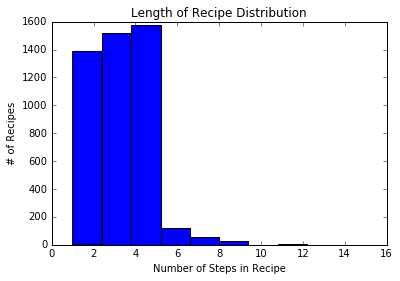

In [57]:
plt.hist([len(y['steps']) for y in recipes],bins= 10)
plt.title("Length of Recipe Distribution")
plt.xlabel("Number of Steps in Recipe")
plt.ylabel("# of Recipes")
plt.show()

## Building the Baseline Model

### Inverted Index

In [281]:
#dictionary of recipe name to recipe ingredients
recipe_ingredients = {}
for recipe in recipes:
    recipe_ingredients[recipe['name']] = recipe['ing']

id_to_name = {}


#inverted index of ingredient to doc IDs
inverted_index = {}
for i in range(len(recipes)):
    for ing in recipes[i]['ing']:
        if ing in inverted_index:
            recipe_indices = [x for x in inverted_index[ing]]
            if i in recipe_indices:
                continue
            else:
                inverted_index[ing].append(i)
        else:
            inverted_index[ing]=[i]
            
idf = {}
for ing in inverted_index.keys():
    num_docs = len(inverted_index[ing])
    idf[ing] = math.log(len(recipes)/float(1+num_docs),2)
    
norms = np.zeros(len(recipes))
for i in range(len(recipes)):
    norm = 0
    for ing in inverted_index.keys():
        for doc in inverted_index[ing]:
            if i == doc:
                norm = norm + (idf[ing])**2
    norms[i] = math.sqrt(norm)

In [286]:
#performs a search based on cosine similarity
def index_search(query, index, idf, norms, recipes):
    results = {}
    query_toks = query.split(",")
    norm_q = 0
    for ing in query_toks:      
        if ing not in index.keys():
            continue
        else:
            norm_q = norm_q + (idf[ing])**2
            for doc in index[ing]:              
                score = idf[ing] * idf[ing]
                if doc in results.keys():
                    results[doc] = results[doc] + score
                else:
                    results[doc] = score
    #normalizing
    for doc in results:
        results[doc] = results[doc]/(float(norms[doc])*(math.sqrt(norm_q)))
    #sorting
    results = sorted(results.items(), key=lambda x: x[1], reverse=True) 
    results = map (lambda t: (t[1], t[0]), results)
    new_results = []
    for (score, doc_id) in results:
        if score != 0:
            new_results.append(recipes[doc_id])
    return new_results

In [287]:
# Some of the recipe names contain non-unicode characters which throw errors 
# so must be checked before applying edit distance
def _edit(query, msg):
    try:
        query = str(query).lower()
    except UnicodeEncodeError:
        query = (query.encode('utf8')).lower()
    
    try:
        msg = str(msg).lower()
    except UnicodeEncodeError:
        msg = (msg.encode('utf8')).lower()
        
    return Levenshtein.distance(query, msg)

In [288]:
# Returns list of tuples (edit_distance,recipe) ordered by edit distance from input recipes
def find_similar(q,transcripts):
    result = []
    for transcript in transcripts:
        m = transcript['name']
        result.append(((_edit(q, m)), transcript))
    return sorted(result, key=lambda tup: tup[0])

In [299]:
def find_recipes(i,r):
# takes string of ingredients and/or recipes

# use both or have different modules to see which one is better
# return the resultant recipe list json that should be parsed

# if recipe(s) given compute similarity of recipe names using edit distance
    transcripts = recipes

    if r != '':
        rec_list = r.split(",")
        recipes_r = [r for l in [find_similar(rec,transcripts) for rec in rec_list] for r in l]
        recipes_r = [r[1] for r in sorted(recipes_r, key=lambda tup: tup[0])]

# if ingredient(s) given compute cosine similarity of recipes  
    if i != '':
        recipes_i = index_search(i,inverted_index,idf,norms,transcripts)
     
    if r !='' and i !='':
        #i_ids = [i['code'] for i in recipes_i]
        #ranked_recipes = [r for r in recipes_r if r['code'] in i_ids]
        ranked_recipes = recipes_i
      
    if r == '':
        ranked_recipes = recipes_i
    
    if i == '':
        ranked_recipes = recipes_r
   
    return ranked_recipes

In [58]:
recipe_index_to_name = {i:name for i,name in enumerate(r['name'] for r in recipes)}
recipe_name_to_index = {name:i for i,name in recipe_index_to_name.iteritems()}
recipe_index_to_verbs = {i:verbs for i,verbs in enumerate(r['verbs'] for r in recipes)}
recipe_index_to_ing = {i:ing for i,ing in enumerate(r['ing'] for r in recipes)}
tokenizer = TreebankWordTokenizer()

In [65]:
def title_sim(recipes):
    title_sims = np.empty([len(recipes), len(recipes)], dtype = np.float32)
    for i in range(len(recipes)):
        for j in range(i, len(recipes)):
            if i == j:
                title_sims[i][j] = 1
                title_sims[j][i] = 1
            else:
                name1 = recipe_index_to_name[i]
                name2 = recipe_index_to_name[j]
                coeff = recipe_comp(name1, name2)
                title_sims[i][j] = coeff[0]
                title_sims[j][i] = coeff[0]
    return title_sims     

In [66]:
def verb_sim(recipes):
    verb_sims = np.empty([len(recipes), len(recipes)], dtype = np.float32)
    for i in range(len(recipes)):
        for j in range(i, len(recipes)):
            if i == j:
                verb_sims[i][j] = 1
                verb_sims[j][i] = 1
            else:
                name1 = recipe_index_to_name[i]
                name2 = recipe_index_to_name[j]
                coeff = recipe_comp(name1, name2)
                verb_sims[i][j] = coeff[1]
                verb_sims[j][i] = coeff[1]
    return verb_sims

In [67]:
def ing_sim(recipes):
    ing_sims = np.empty([len(recipes), len(recipes)], dtype = np.float32)
    for i in range(len(recipes)):
        for j in range(i, len(recipes)):
            if i == j:
                ing_sims[i][j] = 1
                ing_sims[j][i] = 1
            else:
                name1 = recipe_index_to_name[i]
                name2 = recipe_index_to_name[j]
                coeff = recipe_comp(name1, name2)
                ing_sims[i][j] = coeff[2]
                ing_sims[j][i] = coeff[2]
    return ing_sims

In [91]:
def custom_tokenizer(terms):
    return terms.split(",")

n_feats = 5000
tfidf_vec = TfidfVectorizer(binary=True, norm=None, use_idf=False, smooth_idf=False, tokenizer=custom_tokenizer,
                            stop_words='english',max_df=0.8, min_df=10, max_features=n_feats)

all_verbs = [",".join(rec['verbs']) for rec in recipes]
recipe_by_verbs = tfidf_vec.fit_transform(all_verbs)
verbs_by_recipe = sparse.csr_matrix.transpose(recipe_by_verbs)
all_titles = [",".join(rec['name']) for rec in recipes]
recipe_by_titles = tfidf_vec.fit_transform(all_titles)
titles_by_recipe = sparse.csr_matrix.transpose(recipe_by_titles)

In [ ]:
def recipe_comp(name1, name2):
    """ 
    Input: two recipe names
    Returns: a list of length 3 
    [same title coefficient, shared verbs (from recipe instructions) coefficient, 
    shared ingredients coefficient]
    """   
    coefficients = []
    index1 = recipe_name_to_index[name1]
    index2 = recipe_name_to_index[name2]
    #calculating title coefficient
    common_words = ['a', 'and', 'the', 'on', 'with', 'in', 's']
    toks_1 = set([w for w in tokenizer.tokenize(name1) if w not in common_words])
    toks_2 = set([w for w in tokenizer.tokenize(name2) if w not in common_words])
    inter = toks_1.intersection(toks_2)
    union = toks_1.union(toks_2)
    coefficients.append(len(inter)/float(len(union)+1))
    #calculating shared verbs coefficient
    verbs1 = set(recipe_index_to_verbs[index1])
    verbs2 = set(recipe_index_to_verbs[index2])
    inter_verb = verbs1.intersection(verbs2)
    union_verb = verbs1.union(verbs2)
    coefficients.append(len(inter_verb)/float(len(union_verb)+1))
    #calculating shared ingredients coefficient
    ing1 = set(recipe_index_to_ing[index1])
    ing2 = set(recipe_index_to_ing[index2])
    inter_ing = ing1.intersection(ing2)
    union_ing = ing1.union(ing2)
    coefficients.append(len(inter_ing)/float(len(union_ing)+1))
    return coefficients